In [ ]:
import nest_asyncio
nest_asyncio.apply()
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import math
import stan
import arviz as az

In [ ]:
def local_level(num_timesteps=60, init_mu=10, 
                s_obs = 2, s_level=1,
                seeded=False, seed=None):

    if seeded:
        np.random.seed(seed)
    
    mu = np.zeros(num_timesteps+1)
    y = np.zeros(num_timesteps)
    
    mu_err = np.random.normal(loc=0, scale=1, size=num_timesteps)
    obs_err = np.random.normal(loc=0, scale=1, size=num_timesteps)

    # Get seasonal effects
    mu[0] = init_mu

    for t in range(num_timesteps):
        mu[t+1] = mu[t] + s_level * mu_err[t]
        y[t] = mu[t] + s_obs * obs_err[t]

    return mu, y

In [ ]:
N = 100
s_obs = 2
s_level = 1

mu, y = local_level(num_timesteps=N, s_obs=s_obs, s_level=s_level, seeded=True, seed=5)

In [ ]:
fig, ax = plt.subplots(1, figsize=(5,4))
ax.plot(y, label='emissions', color='k', alpha=.6)
ax.plot(mu, label = 'level', color='darkorange')
fig.legend()

In [ ]:
level_code = """
data {
  int<lower=0> N;         // # observations
  real y[N];              // observations
}
parameters {
  vector[N] mu_err;       // level innovation
  vector[N] obs_err;       // level innovation
  real<lower=0> s_level;
  real<lower=0> s_obs;
}
transformed parameters {
  vector[N] mu;           // level 
  mu[1] = mu_err[1];

  for (t in 2:N) {
    mu[t] = mu[t-1] + s_level * mu_err[t];
  }
}
model {
  mu_err ~ normal(0,1);
  obs_err ~ normal(0,1);
  s_obs ~ normal(2, 1);
  s_level ~ normal(1, 1);

  y ~ normal(mu, s_obs);
}
generated quantities {
  vector[N] y_hat;
  
  for (t in 1:N) {
    y_hat[t] = mu[t] + s_obs * obs_err[t];
  }

}
"""

In [ ]:
level_data = {"N": N,
                "y": y,}
level_data

In [ ]:
%%capture
model = stan.build(level_code, data=level_data, random_seed=1);
posterior = model.sample(num_chains=4, num_samples=1000)

In [ ]:
prior_only = """
data {
  int<lower=0> N;         // # observations
  real y[N];              // observations
}
parameters {
  vector[N] mu_err;       // level innovation
  vector[N] obs_err;       // level innovation
  real<lower=0> s_level;
  real<lower=0> s_obs;
}
transformed parameters {
  vector[N] mu;           // level 
  mu[1] = mu_err[1];

  for (t in 2:N) {
    mu[t] = mu[t-1] + s_level * mu_err[t];
  }
}
model {
  mu_err ~ normal(0,1);
  obs_err ~ normal(0,1);
  s_obs ~ normal(2, 1);
  s_level ~ normal(1, 1);

  //y ~ normal(mu, s_obs);
}
generated quantities {
  vector[N] y_hat;
  
  for (t in 1:N) {
    y_hat[t] = mu[t] + s_obs * obs_err[t];
  }

}
"""

In [ ]:
%%capture
prior_model = stan.build(prior_only, data=level_data, random_seed=1);


In [ ]:
prior_posterior = prior_model.sample(num_chains=4, num_samples=1000)

In [ ]:
fitsum = az.summary(posterior)
fitsum

In [419]:
sum_prior = az.summary(prior_posterior)

In [417]:
prior_inference = az.from_pystan(posterior=prior_posterior, posterior_predictive=["y_hat"], posterior_model=prior_model, observed_data=['y'])


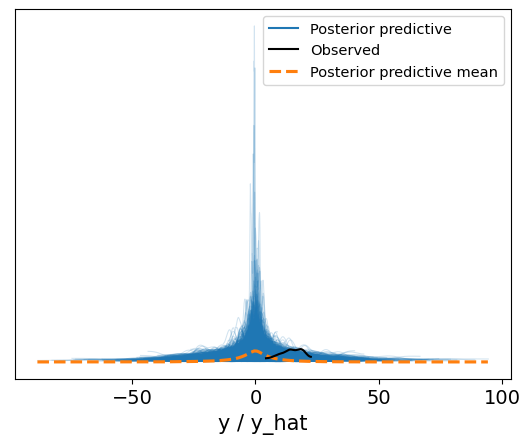

In [418]:
ax_prior = az.plot_ppc(prior_inference, data_pairs={'y': "y_hat"})


In [ ]:
idata = az.from_pystan(posterior=posterior, posterior_predictive=["y_hat"], posterior_model=model, observed_data=['y'])
idata

In [ ]:
az.rhat(idata)

In [ ]:
ax = az.plot_ppc(idata, data_pairs={'y': "y_hat"})


In [ ]:
ax.show()

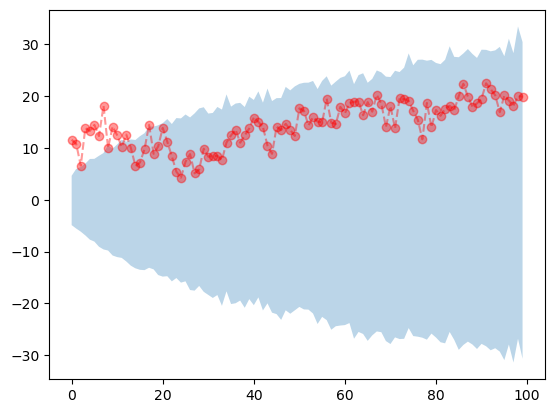

In [420]:
plt.fill_between(
    range(0,100),
    sum_prior['y_hat[0]':'y_hat[99]']['hdi_97%'].values,
    sum_prior['y_hat[0]':'y_hat[99]']['hdi_3%'].values,
    alpha=.3
    )
#plt.plot(y, linestyle="--", marker="o", alpha=.4, color='r')
#plt.plot(fitsum['mu[0]':'mu[98]']['mean'].values, color='b', linestyle="--")
